# Microwave Ocean Surface Emission with ARTS

This notebook demonstrates how to use the TELSEM and FASTEM interfaces in ARTS to include microwave surface emission in radiative transfer calculations.

In [46]:
%env ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simonpf/build/arts/
import sys
sys.path.append("..")
sys.path.append("/home/simonpf/src/typhon/")
import utils.setup
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

env: ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simonpf/build/arts/


## Simulation Setup

In [47]:
from typhon.arts.workspace import Workspace

ws = Workspace()
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

ARTS[56579232]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[56579232]: {
ARTS[56579232]: - verbosityInit
ARTS[56579232]: - scat_speciesSet
ARTS[56579232]: - MatrixSet
ARTS[56579232]: - Tensor4SetConstant
ARTS[56579232]: - ArrayOfStringSet
ARTS[56579232]: - Touch
ARTS[56579232]: - FlagOff
ARTS[56579232]: - MatrixSet
ARTS[56579232]: - NumericSet
ARTS[56579232]: - ArrayOfStringSet
ARTS[56579232]: - Tensor3SetConstant
ARTS[56579232]: - Tensor3SetConstant
ARTS[56579232]: - Tensor3SetConstant
ARTS[56579232]: - Tensor3SetConstant
ARTS[56579232]: - Tensor3SetConstant
ARTS[56579232]: - Tensor3SetConstant
ARTS[56579232]: - IndexSet
ARTS[56579232]: - IndexSet
ARTS[56579232]: - IndexSet
ARTS[56579232]: - IndexSet
ARTS[56579232]: - FlagOff
ARTS[56579232]: - output_file_formatSetAscii
ARTS[56579232]: - StringSet
ARTS[56579232]: - IndexSet
ARTS[56579232]: - abs_lineshapeDefine
ARTS[56579232]: - NumericSet
ARTS[56579232]: - NumericSet
ARTS[56579232]: - AgendaSet
ARTS[565792

In [48]:
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

In [49]:
ws.stokes_dim = 2
ws.cloudboxOff()
ws.jacobianOff()

In [50]:
ws.VectorNLogSpace( ws.p_grid, 200, 1013e2, 10.0 )
ws.abs_speciesSet( species=["N2", "O2", "H2O"] )
# Read a line file and a matching small frequency grid
ws.abs_linesReadFromSplitArtscat(
    ws.abs_species,
    "spectroscopy/Perrin/",
    10e9,
    250e9
    )
# Sort the line file according to species
ws.abs_lines_per_speciesCreateFromLines()

In [51]:
from typhon.arts.workspace.variables import *

ws.VectorNLogSpace( ws.p_grid, 200, 1013e2, 10.0 )
# Atmospheric scenario
ws.AtmRawRead( basename="planets/Earth/Fascod/midlatitude-summer/midlatitude-summer" )

# Create a frequency grid
ws.VectorNLinSpace( f_grid, 1000, 10e+9, 250e+9 )
# No sensor properties
ws.sensorOff()
# We select here to use Planck brightness temperatures
ws.StringSet( iy_unit, "PlanckBT" )
# Extract optical depth as auxiliary variables
ws.ArrayOfStringSet( iy_aux_vars, [ "Optical depth"] )
# Create vector container for the optical depth
odepth = ws.VectorCreate()

In [52]:
import numpy as np
# Atmosphere and surface
ws.AtmosphereSet1D()
ws.AtmFieldsCalc()
ws.Extract( ws.z_surface, ws.z_field, 0 )
ws.Extract( ws.t_surface, ws.t_field, 0 )

# Definition of sensor position and line of sight (LOS)
ws.MatrixSet( ws.sensor_pos, np.array([[180.0]])) # 10e3 for sensor in z = 10 km
ws.MatrixSet( ws.sensor_los, np.array([[180.0]])) # zenith angle: 0 looking up, 180 looking nadir

# Perform RT calculations
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()

## Surface Agendas

In [53]:
import numpy as np
from typhon.arts.workspace import arts_agenda

ws.NumericCreate("wind_speed")
ws.NumericCreate("wind_direction")
ws.VectorCreate("transmittance")
ws.wind_speed     = 0.0
ws.wind_direction = 0.0
ws.transmittance  = 0.1 * np.ones(ws.f_grid.value.shape)

@arts_agenda
def surface_fastem(ws):
    ws.Print("bla", 3)
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceFastem(wind_speed     = ws.wind_speed,
                     wind_direction = ws.wind_direction,
                     transmittance  = ws.transmittance)
    
@arts_agenda
def surface_tessem(ws):
    ws.specular_losCalc()
    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
    ws.surfaceTessem(wind_speed     = ws.wind_speed)

### Fastem Calculations

In [54]:
ws.Copy(ws.surface_rtprop_agenda, surface_fastem)
ws.yCalc()
y_fastem = np.copy(ws.y)

### Tessem Calculations

In [55]:
ws.TessemNNReadAscii(tessem_neth, "testdata/tessem_sav_net_H.txt")
ws.TessemNNReadAscii(tessem_netv, "testdata/tessem_sav_net_V.txt")

ws.Copy(ws.surface_rtprop_agenda, surface_tessem)
ws.yCalc()
y_tessem = np.copy(ws.y)

## Results

In [56]:
y_fastem, y_tessem

(array([ 111.83841995,    0.46465827,  112.03800338, ...,    1.01249925,
         227.48870611,    1.00814075]),
 array([  6.81012259,   0.04842756,   6.82598278, ...,   0.28880399,
         18.87421898,   0.28786066]))

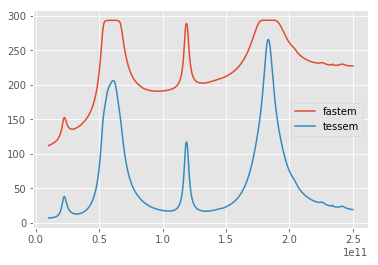

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ws.f_grid.value, y_fastem[0::2], c = "C0", ls = "-", label="fastem")
plt.plot(ws.f_grid.value, y_tessem[0::2], c = "C1", ls = "-", label="tessem")
plt.legend()